In [2]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
import scipy.stats as ss
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
df = pd.read_csv("data/diabetes.csv")
df = df[df["BMI"]>10]
dfD = df[df["Outcome"]==1]
dfN = df[df["Outcome"]==0]
dPos = dfD.BMI
dNeg = dfN.BMI
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Effect Size and Comparing Samples

We previously looked at how we can take data samples and generalize those to an expectation of the population, as well as a measure of our expected accuracy. We can apply similar concepts to comparing two samples to each other. When we estimated for a population we always had a confidence interval - we can't really state exactly what the population mean will be, we can only give a range and a level of certainty. A similar idea occurs when doing a comparison - we can't really just take the means of each sample and do a simple comparison, since there is that level of uncertainty if our samples really represent the population. What we need to do is to execute a comparison that incorporates that uncertainty as a factor, and rather than producing a definitive statement of difference we will produce a probabilistic one. 

This type of comparison is very common, one example is if we are running a scientific trial such as a drug trial. We want to compare the people who got the treatment with the people who didn't, and attempt to establish if that treatment casues those two samples to be different. 

## Do Diabetics Have a Higher BMI than Normals?

This question is both simple and complex - it is easy to say if two things are different at a glance. Analytically though, it becomes more complex. Is that difference significant or irrelevant? Is it due to chance or because of some effect? Stating that a difference matters is not so simple...

Below we'll look at different ways that we can express an answer to this question, starting with just taking the mean/median, and finishing with effect size. 

<b>First - what are the stats?</b>

In [4]:
#Basics
print("Non-Diabetics mean and median", dNeg.mean(), dNeg.median())
print("Diabetics mean and median", dPos.mean(), dPos.median())

Non-Diabetics mean and median 30.859674134419553 30.1
Diabetics mean and median 35.40676691729323 34.3


<AxesSubplot:xlabel='BMI', ylabel='Density'>

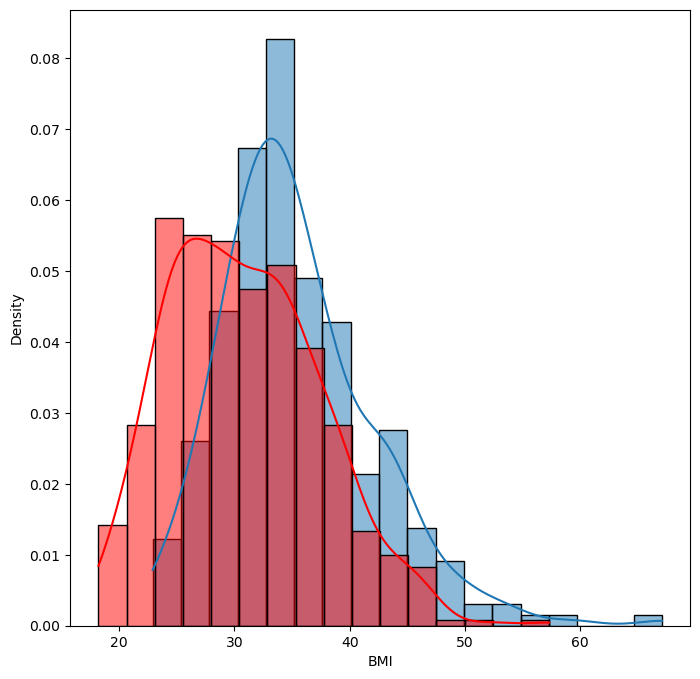

In [5]:
#plot em
sns.histplot(dPos, kde=True, stat="density")
sns.histplot(dNeg, kde=True, stat="density", color='red')


<h3>Looks pretty likely, we should test it though...</h3>

* Without knowing more about the distributions (like the standard deviations) it's hard to interpret whether a difference like this is a lot or not.

* The magnitude of the difference depends on the units of measure, making it hard to compare across different studies.

There are a number of ways to quantify the difference between distributions.  A simple option is to express the difference as a percentage of the mean.

**Exercise 1**: what is the relative difference in means, expressed as a percentage?

In [26]:
#Compute percentage difference
diff_means1 = (dPos.mean() - dNeg.mean()) / dPos.mean()
diff_means2 = (dPos.mean() - dNeg.mean()) / dNeg.mean()

diff_means1, diff_means2

(0.12842439959274585, 0.14734740111212152)

The problem here with relative differences is that you have to choose which mean to express them relative to.
<br><br>

## Part Two - Are Things Different?

Remember, what we are trying to express here when comparing two distributions is to evaluate if one is significantly different from the other. The word significant is doing a lot of work here, if one distribution is clearly, 100% bigger than the other one, that is a simple question; in every case that is worth examining, the difference is not so clear, and the distributions will overlap some, often a lot. 

We don't have a definitve calculation to express "bigger" like we would with two integers, we can measure degrees of difference between the two distributions, which is what we will do here. We can also measure the likelihood that the difference is real, and not due to randomness, which we will do in hypothesis testing in about 2 classes. 

One way to express the difference between distributions is to see how much they overlap.  To define overlap, we choose a threshold between the two means - this will allow us to calculate the ability of the two different distributions to differentiate between the classes.  The simple threshold is the midpoint between the means:

In [7]:
posMean, negMean, posSTD, negSTD, posMed, negMed = dPos.mean(), dNeg.mean(), dPos.std(), dNeg.std(), dPos.median(), dNeg.median()
simple_thresh = (posMean + negMean) / 2
simple_thresh

33.133220525856395

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [8]:
thresh = (posSTD * negMean + negSTD * posMean) / (posSTD + negSTD)
thresh

33.123860154046554

In this example, there's not much difference between the two thresholds.

Now we can count how many diabetics are below the threshold. Here we are making an assumption for the purposes of this investigation - we are assuming that the BMI for diabetics "should" be higher, and we are establishing evidence of if this is true or not. 

In [9]:
pos_below_thresh = sum(dPos < thresh)
pos_below_thresh

109

And how many non-diabetics are above it:

In [10]:
neg_above_thresh = sum(dNeg > thresh)
neg_above_thresh

179

The "overlap" is the area under the curves that ends up on the wrong side of the threshold.

In [11]:
pos_overlap = pos_below_thresh / len(dPos)
neg_overlap = neg_above_thresh / len(dNeg)
pos_overlap, neg_overlap

(0.40977443609022557, 0.3645621181262729)

In practical terms, you might report the fraction of people who would be misclassified if you tried to use BMI to guess diabeticness, which is the average of the positive and negative overlap rates:

In [12]:
misclassification_rate = (pos_overlap + neg_overlap) / 2
misclassification_rate

0.38716827710824925

Think - ideally, if the diabetic/not-diabetic split was a really good predictor of BMI we'd want this to be as discriminatory as possible. The more overlap, the less diabetic 'means' to the BMI. If the two groups are perfectly separated, the BMI would be a perfect predictor here - every diabetic BMI would be greater than every non-diabetic one. The less likely this is, the less differentiated the two groups are. 

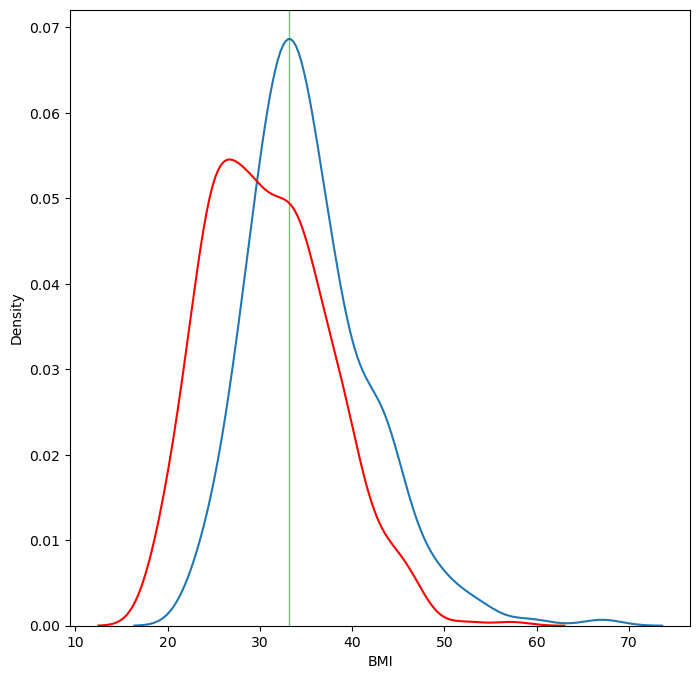

In [13]:
sns.kdeplot(dPos)
sns.kdeplot(dNeg, color='red')
thinkplot.axvline(thresh, color="green")

<b>Note: the threshold line almost hitting the peak of the curve above is just a coincidence. </b>

##### Superiority 

Another way to quantify the difference between distributions is what's called "probability of superiority", which is a problematic term, but in this context it's the probability that a randomly-chosen diabetic has a higher BMI than a randomly-chosen non-diabetic.

**Exercise 2**:  Suppose I choose a diabetic and a normal at random.  What is the probability that the diabetic has a higher BMI?

HINT: You can `zip` the two samples together and count the number of pairs where the diabetic has a higher BMI, or use NumPy array operations.

In [27]:
sum(x > y for x, y in zip(dPos, dNeg)) / len(dPos)

0.6654135338345865

This translates into a statement that for any two people that are selected from the two samples, the diabetic will have an X percentage probability of having an higher BMI. 

## Cohen's effect size

There is one other common way to express the difference between distributions - our old friend Cohen and his Effect Size.  Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation.  Here's the math notation:

$ d = \frac{\bar{x}_1 - \bar{x}_2} s $

where $s$ is the pooled standard deviation:

$s = \sqrt{\frac{n_1 s^2_1 + n_2 s^2_2}{n_1+n_2}}$

Here's a function that computes it:

In [14]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it.  This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups. We can read it to mean that the effect side is sort of the difference between the two groups, compared to the overall varaiance of all the data. So higher values indicate that the difference between the groups is "outweighing" the varaince in the values, and low effect sizes indicate that the varaiance in the values outweighs the difference in the groups. Note, this is not a technical definition, it is a way to think of it. 

And here's the result for the difference in BMI between diabetics and normals.

In [15]:
CohenEffectSize(dPos, dNeg)

0.6910633931865532

It isn't really super obvious what this value means, unfortunately. We can use the chart of effect size meaning from Cohen that we looked at before and say that this is a medium-large effect - or the fact of someone being diabetic or not has a 'pretty big' impact on the BMI of that person. 

![Effect Size](images/effect_size_scale.png "Effexct Size")


<h2>Visualizing what Cohen's Effect Size looks like</h2>

Here's the function that takes Cohen's $d$, plots normal distributions with the given effect size, and prints their overlap and superiority. We can look at this to get an idea of what the values we may get for Cohen are visually. 

Here's a function that encapsulates the code we already saw for computing overlap and probability of superiority.

In [16]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = (treatment_sample > control_sample).mean()
    return overlap, superiority

In [17]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

In [18]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = ss.norm(0, 1)
    treatment = ss.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    plt.fill_between(xs, ys, label='control', color='C1', alpha=0.5)

    xs, ys = eval_pdf(treatment)
    plt.fill_between(xs, ys, label='treatment', color='C0', alpha=0.5)
    
    o, s = overlap_superiority(control, treatment)
    plt.text(0, 0.05, 'overlap ' + str(o))
    plt.text(0, 0.15, 'superiority ' + str(s))
    plt.show()
    #print('overlap', o)
    #print('superiority', s)

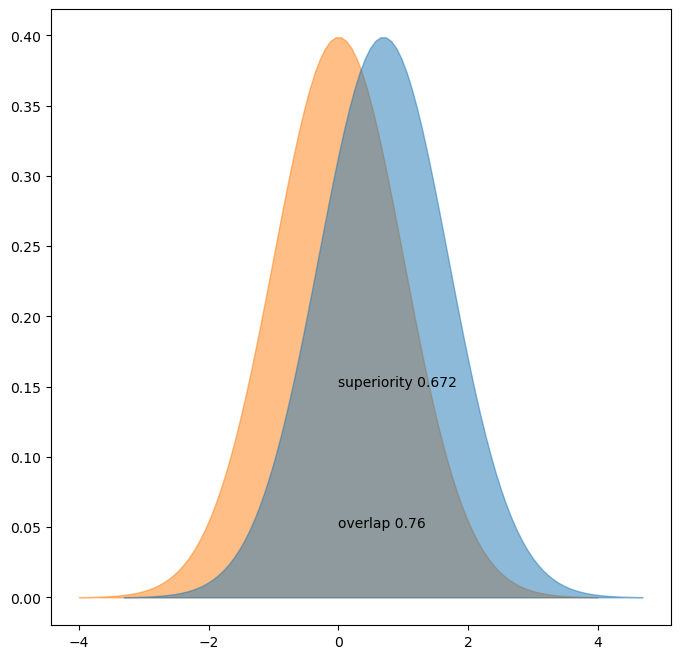

In [19]:
dCohen = CohenEffectSize(dPos, dNeg)
plot_pdfs(dCohen)

##### Results

We can get a degree of intuitive sense on how the effect size translates to the appearance on a pdf chart. Two distributions can have a statistically significant difference from each other without looking dramatically separated on a graph. 

##### Adjustable Cohen

The chart below does the same basic thing, but we can use a little widget in Python that allows us to edit the value for the effect size dynamically. This is stuff that comes from the ipywidgets stuff imported above. We can use stuff like this to make interactive bits, pretty easily - here we replace the input to the Cohen Effect Size paramater with the value from the little slide object, and wraps the plot in that "interact" bubble, which allows it to auto-update. Things like this aren't really things we explicitly cover all that much in this class, but they are useful to know of, at least. 

##### Important Note:

Over the long run, if you do this stuff regularly, it may make sense to start building up "utility" files, which are files that basically hold a bunch of useful stuff that you can reuse. In data science, things that we've seen already such as pariplots, describes, histograms, outlier identification, and the like are commonly repeated in the same basic way. Creating a function that can take a dataset and do all this exploratory stuff en masse is a useful exercise that both has benefits in its usability, and is a good code exercise. If you don't have to recode it over and over, it also frees up some time to consider cool additions like this - for example, one could filter out outliers greater than "slider" standard deviations out. We'll do a version of this as part of the first assignment in the ML course later. Food for thought. 

In [20]:
slider = widgets.FloatSlider(min=0, max=4, value=dCohen)
interact(plot_pdfs, cohen_d=slider)

interactive(children=(FloatSlider(value=0.6910633931865532, description='cohen_d', max=4.0), Output()), _dom_c…

<function __main__.plot_pdfs(cohen_d=2)>

#### Effect Size - What Did We Find?

We want to be able to say if there's a real difference between group A and group B. All of the caclualtions above are different ways to demonstrate that - they aren't the only ways!

<b>Cohen's Effect Size is a very good metric to use to express if two samples are different. We'll explore more with hypothesis tests soon. </b>

## Odds

We can look at at similar problem - <b>how likely is it that someone with or without diabetes has a BMI that is obese (>=30)?</b>

Odds ratios are another type of effect size. 

In [21]:
#Probability of being overweight
pPos = sum(dPos >= 30)/len(dPos)
pNeg = sum(dNeg >= 30)/len(dNeg)
pPos, pNeg

(0.8233082706766918, 0.515274949083503)

How much of a difference does being diabetic make?

In [22]:
pPos/pNeg, pNeg/pPos

(1.5978037980326312, 0.6258590705763096)

##### Being diabetic increases the chances of being obese by 159%. But being not diabetic decreases chances of obesity by 63%. What is the right way to express this?

Probabilities are pretty high! We can express probabilities in a slightly different way as well - as odds.

odds = p/(1-p)

Odd are just the ratio of the likelihood something happens to the likelihood that it doesn't.

If you've ever gambled, you've seen odds, eg if there is a game between two teams, and one is heavily favored you may see odds like
<ul>
<li>Miami Dolphins 11/2 (+550)
<li>Buffalo Bills 2/19 (-850)
</ul>

This means that for every two dollars you bet on Miami you'll win 11 - they are much less likely to win. For every 19 dollars you bet on Buffalo, you'l only win 2! They are extremely likely to win. (Gambling note: if you win in either case, you get back the original bet - the odds only look at winnings.) (Gambling note #2, in North America we normally use the +/- version, which are expressed in terms of "what would happen if I bet $100, called American odds.)

In [23]:
#Calculate odds
oddPos = pPos/(1-pPos)
oddNeg = pNeg/(1-pNeg)
oddPos, oddNeg

(4.659574468085108, 1.0630252100840334)

In [24]:
#We can  calculate a ratio of these two
oddPos/oddNeg, oddNeg/oddPos

(4.383315112269786, 0.2281378304746555)

So... being diabetic increases chances of obesity (or=4.4). 

Or 

Not being diabetic decreases chances of obesity (or=.23)

<b>Which one matters? It isn't really clear.</b>


##### Can math help? Take the Log...

We'll take the log of each of these odds, a value conviniently named the Log Odds. This gives us a symetrical way to express the difference in probabilities, something that is not directly super useful for us now, but will be important in a little while. 

In [25]:
#Log of the odds.
logNeg = np.log(oddNeg/oddPos)
logPos = np.log(oddPos/oddNeg)
logNeg, logPos

(-1.4778053130503972, 1.4778053130503972)

<b>Same, same!!!</b>

This is called the log odds ratio, or logit. Put this into your back pocket, it becomes important when we want to start predicting things pretty soon....

Log odds ratio is excellent for comparisons of probabilites, it is symetric and we can compare accross studies. On the downside, it is kind of a meaningless metric to most people - the number themselves don't really hacve context. On the double plus side, this is the building block of classifications, specifically logistic regression, which we'll look at more soon. 